In [ ]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Paths
original_data_dir = '/content/drive/MyDrive/grad_data'  # Parent directory containing 'normal' and 'dyslexic' folders
split_base_dir = '/content/drive/MyDrive/grad_data/split_dataset'  # Where to store the split datasets
checkpoint_path = '/content/drive/MyDrive/grad_data/best_model.pth'  # Model checkpoint path
resume_checkpoint_path = '/content/drive/MyDrive/grad_data/resume_checkpoint.pth'


# Class names (should match your folder names)
class_names = ['dyslexic', 'normal']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Prepare Dataset with stratified splitting
def prepare_dataset():
    if os.path.exists(split_base_dir):
        shutil.rmtree(split_base_dir)
    os.makedirs(split_base_dir, exist_ok=True)

    for split in ['train', 'val', 'test']:
        for cls in class_names:
            os.makedirs(os.path.join(split_base_dir, split, cls), exist_ok=True)

    # Collect all images with their labels for stratified splitting
    all_images = []
    all_labels = []

    for label, cls in enumerate(class_names):
        full_path = os.path.join(original_data_dir, cls)
        if not os.path.exists(full_path):
            print(f"Warning: Directory {full_path} does not exist!")
            continue

        images = [img for img in os.listdir(full_path)
                 if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

        for img in images:
            all_images.append(os.path.join(full_path, img))
            all_labels.append(cls)

    if len(all_images) == 0:
        raise ValueError("No images found in the dataset directory!")

    # Stratified split: 70% train, 15% val, 15% test
    train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
        all_images, all_labels, test_size=0.3, stratify=all_labels, random_state=42
    )

    val_imgs, test_imgs, val_labels, test_labels = train_test_split(
        temp_imgs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )

    # Copy files to respective directories
    for img_path, label in zip(train_imgs, train_labels):
        shutil.copy(img_path, os.path.join(split_base_dir, 'train', label))

    for img_path, label in zip(val_imgs, val_labels):
        shutil.copy(img_path, os.path.join(split_base_dir, 'val', label))

    for img_path, label in zip(test_imgs, test_labels):
        shutil.copy(img_path, os.path.join(split_base_dir, 'test', label))

    print(f"Dataset split completed:")
    print(f"Train: {len(train_imgs)} images")
    print(f"Validation: {len(val_imgs)} images")
    print(f"Test: {len(test_imgs)} images")

In [ ]:
# Custom Dataset with error handling
class DyslexiaDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.images = []
        self.labels = []

        for label, cls in enumerate(class_names):
            cls_folder = os.path.join(folder, cls)
            if not os.path.exists(cls_folder):
                continue

            for img in os.listdir(cls_folder):
                img_path = os.path.join(cls_folder, img)
                try:
                    # Test if image can be opened
                    Image.open(img_path).convert('RGB')
                    self.images.append(img_path)
                    self.labels.append(label)
                except Exception as e:
                    print(f"Skipping corrupted image: {img_path}")
                    continue

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image as fallback
            image = Image.new('RGB', (224, 224), (0, 0, 0))
            if self.transform:
                image = self.transform(image)
            return image, self.labels[idx]

In [ ]:
# Enhanced transforms with data augmentation
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Prepare dataset
try:
    prepare_dataset()
except Exception as e:
    print(f"Error preparing dataset: {e}")
    exit(1)

Dataset split completed:
Train: 2148 images
Validation: 460 images
Test: 461 images


In [ ]:
# Datasets & Loaders
BATCH_SIZE = 32
train_dataset = DyslexiaDataset(os.path.join(split_base_dir, 'train'), train_transforms)
val_dataset = DyslexiaDataset(os.path.join(split_base_dir, 'val'), test_transforms)
test_dataset = DyslexiaDataset(os.path.join(split_base_dir, 'test'), test_transforms)

if len(train_dataset) == 0:
    raise ValueError("No training data found!")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 2148
Validation samples: 460
Test samples: 461


In [ ]:
# Load pretrained ResNet
model = models.resnet18(pretrained=True)

# Progressive unfreezing approach
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Initially freeze all layers
set_parameter_requires_grad(model, feature_extracting=True)

# Replace final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Only train classifier initially

# LR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cpu


In [ ]:
# Function to save complete checkpoint
def save_checkpoint(model, optimizer, scheduler, epoch, best_acc, history, filepath):
    """Save complete training state"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_acc': best_acc,
        'history': history
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at epoch {epoch + 1}")

In [ ]:
# Function to load checkpoint
def load_checkpoint(filepath, model, optimizer, scheduler):
    """Load complete training state"""
    if os.path.exists(filepath):
        print(f"Loading checkpoint from {filepath}")
        checkpoint = torch.load(filepath, map_location=device)

        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        start_epoch = checkpoint['epoch'] + 1
        best_acc = checkpoint['best_acc']
        history = checkpoint['history']

        print(f"Resuming training from epoch {start_epoch}")
        print(f"Best accuracy so far: {best_acc:.4f}")

        return start_epoch, best_acc, history
    else:
        print("No checkpoint found, starting from scratch")
        return 0, 0.0, {'train_loss': [], 'val_loss': [], 'val_acc': []}

In [ ]:
# Improved training function with checkpoint resuming
def train_model(model, train_loader, val_loader, epochs=15, patience=5, resume=True):
    # Initialize optimizer and scheduler before resuming
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    if resume:
        start_epoch, best_acc, history = load_checkpoint(resume_checkpoint_path, model, optimizer, scheduler)
        epochs_no_improve = 0
        best_epoch = start_epoch - 1 if start_epoch > 0 else 0
        print(f"✅ Resumed from checkpoint at epoch {start_epoch} with best val acc {best_acc:.4f}")
    else:
        start_epoch = 0
        best_acc = 0.0
        history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
        epochs_no_improve = 0
        best_epoch = 0

    for epoch in range(start_epoch, epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')
        print('-' * 20)

        # Training phase
        model.train()
        running_loss = 0.0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / total

        # Store metrics
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch
            epochs_no_improve = 0
            torch.save(model.state_dict(), checkpoint_path)
            print(f'✅ New best model saved with Val Acc: {best_acc:.4f}')
        else:
            epochs_no_improve += 1

        # Save resume checkpoint every epoch
        save_checkpoint(model, optimizer, scheduler, epoch, best_acc, history, resume_checkpoint_path)

        # Early stopping
        if epochs_no_improve >= patience:
            print(f'⏹️ Early stopping triggered after {patience} epochs without improvement')
            break

        # Unfreeze more layers after initial epochs
        if epoch == 5 and start_epoch <= 5:
            print("🔓 Unfreezing layer4 for fine-tuning...")
            for param in model.layer4.parameters():
                param.requires_grad = True
            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        scheduler.step()

    print(f'\nTraining completed. Best Val Acc: {best_acc:.4f} at epoch {best_epoch + 1}')

    # Clean up resume checkpoint after successful completion
    if os.path.exists(resume_checkpoint_path):
        os.remove(resume_checkpoint_path)
        print("Resume checkpoint cleaned up")

    return history


In [ ]:
# Train the model (with resume capability)
EPOCHS = 15
print("Starting training...")
print("Note: Training will automatically resume from the last checkpoint if available")
history = train_model(model, train_loader, val_loader, epochs=EPOCHS, patience=7, resume=True)

# Load best model and evaluate on test set
print("\nEvaluating on test set...")
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

Starting training...
Note: Training will automatically resume from the last checkpoint if available
No checkpoint found, starting from scratch
✅ Resumed from checkpoint at epoch 0 with best val acc 0.0000

Epoch 1/15
--------------------
Batch 0/68, Loss: 0.6554
Batch 10/68, Loss: 0.6647
Batch 20/68, Loss: 0.6277
Batch 30/68, Loss: 0.5577
Batch 40/68, Loss: 0.5559
Batch 50/68, Loss: 0.6448
Batch 60/68, Loss: 0.5561
Train Loss: 0.6357, Val Loss: 0.5517, Val Acc: 0.6696
✅ New best model saved with Val Acc: 0.6696
Checkpoint saved at epoch 1

Epoch 2/15
--------------------
Batch 0/68, Loss: 0.5450
Batch 10/68, Loss: 0.4853
Batch 20/68, Loss: 0.5436
Batch 30/68, Loss: 0.5061
Batch 40/68, Loss: 0.4868
Batch 50/68, Loss: 0.4712
Batch 60/68, Loss: 0.5955
Train Loss: 0.5273, Val Loss: 0.4527, Val Acc: 0.8391
✅ New best model saved with Val Acc: 0.8391
Checkpoint saved at epoch 2

Epoch 3/15
--------------------
Batch 0/68, Loss: 0.3875
Batch 10/68, Loss: 0.5376
Batch 20/68, Loss: 0.7663
Batch

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Batch 0/68, Loss: 0.3733
Batch 10/68, Loss: 0.3084
Batch 20/68, Loss: 0.2512
Batch 30/68, Loss: 0.2354
Batch 40/68, Loss: 0.2055
Batch 50/68, Loss: 0.2944
Batch 60/68, Loss: 0.2291
Train Loss: 0.3037, Val Loss: 0.1202, Val Acc: 0.9543
✅ New best model saved with Val Acc: 0.9543
Checkpoint saved at epoch 7

Epoch 8/15
--------------------
Batch 0/68, Loss: 0.2310
Batch 10/68, Loss: 0.3478
Batch 20/68, Loss: 0.4217
Batch 30/68, Loss: 0.1928
Batch 40/68, Loss: 0.1050
Batch 50/68, Loss: 0.0813
Batch 60/68, Loss: 0.2851
Train Loss: 0.2406, Val Loss: 0.2919, Val Acc: 0.8609
Checkpoint saved at epoch 8

Epoch 9/15
--------------------
Batch 0/68, Loss: 0.1884
Batch 10/68, Loss: 0.2102
Batch 20/68, Loss: 0.0853
Batch 30/68, Loss: 0.1583
Batch 40/68, Loss: 0.1453
Batch 50/68, Loss: 0.3217
Batch 60/68, Loss: 0.1195
Train Loss: 0.1999, Val Loss: 0.0746, Val Acc: 0.9783
✅ New best model saved with Val Acc: 0.9783
Checkpoint saved at epoch 9

Epoch 10/15
--------------------
Batch 0/68, Loss: 0.511

In [ ]:
# Classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

    dyslexic       0.99      0.98      0.98       231
      normal       0.98      0.99      0.98       230

    accuracy                           0.98       461
   macro avg       0.98      0.98      0.98       461
weighted avg       0.98      0.98      0.98       461


Confusion Matrix:
[[226   5]
 [  3 227]]


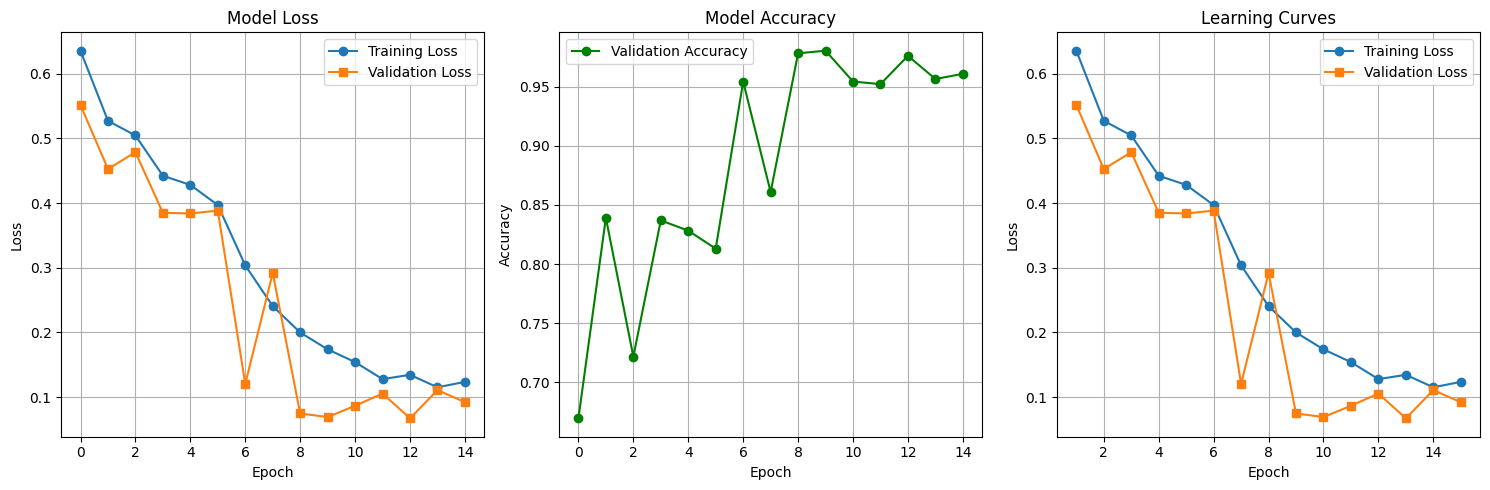

In [ ]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Training Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history['val_acc'], label='Validation Accuracy', marker='o', color='green')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
# Learning curve
train_sizes = list(range(1, len(history['train_loss']) + 1))
plt.plot(train_sizes, history['train_loss'], 'o-', label='Training Loss')
plt.plot(train_sizes, history['val_loss'], 's-', label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def predict_image(img_path, model, transform, device):
    """Predict class for a single image and optionally display it"""
    model.eval()
    try:
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)
            probabilities = torch.nn.functional.softmax(output[0], dim=0)
            _, pred = torch.max(output, 1)

        predicted_class = class_names[pred.item()]
        confidence = probabilities[pred.item()].item()

        # Show image with prediction
        plt.imshow(img)
        plt.title(f"Prediction: {predicted_class} ({confidence:.2f})")
        plt.axis('off')
        plt.show()

        return predicted_class, confidence
    except Exception as e:
        print(f"Error predicting image: {e}")
        return None, None


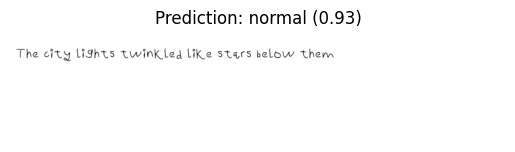

🧠 Predicted class: normal
🎯 Confidence: 0.9326


In [ ]:
# Predict local image
img_path = '/content/drive/MyDrive/grad_data/test3.png'  # make sure it's in the same folder
predicted_class, confidence = predict_image(img_path, model, test_transforms, device)
if predicted_class:
    print(f"🧠 Predicted class: {predicted_class}")
    print(f"🎯 Confidence: {confidence:.4f}")
